In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import itertools
from itertools import compress, product

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from IPython import display
import seaborn as sns

In [2]:
model = nn.Sequential(
    nn.Linear(15, 5),
    nn.ReLU(),
    
    nn.Linear(5, 10),
    nn.ReLU(),
    
    nn.Linear(10, 15),
    nn.ReLU(),
    
    nn.Linear(15, 20),
    nn.ReLU(),
    
    nn.Linear(20, 15),
    nn.ReLU(),
    
    nn.Linear(15, 10),
    nn.ReLU(),
    
    nn.Linear(10, 5),
    nn.ReLU(),
    
    nn.Linear(5, 3),
    nn.Softmax(),
)

In [3]:
actions_0_MountainCar= np.load("MountainCar/MountainCar_actions_2.npy")
states_0_MountainCar= np.load("MountainCar/MountainCar_states_2.npy")

actions_0_MountainCar = torch.tensor(actions_0_MountainCar, dtype=torch.long)
states_0_MountainCar = torch.tensor(states_0_MountainCar, dtype=torch.float)

print("states_0_MountainCar.shape",states_0_MountainCar.shape)
print("actions_0_MountainCar.shape",actions_0_MountainCar.shape)

states_0_MountainCar.shape torch.Size([5000, 200, 2])
actions_0_MountainCar.shape torch.Size([5000, 200, 1])


In [4]:
# def pre_processing (states, actions, n=3):
#     ep, t, state_size = states.shape
#     _,_, action_space = actions.shape
#     output = torch.zeros ((ep*(t-n-1), n*(state_size+action_space)+action_space))
#     index=0
#     indices = []
#     for i in range (ep):
#         for j in range (t-n-1):
#             output[index, : state_size*n] = states[i, j+1:j+n+1].view(-1)
#             output[index, state_size*n: ]  = actions[i, j:j+n+1].view(-1)
#             index+=1
#     for i in range (output.shape[0]):
#         if (output[i,-1] < torch.zeros((n+1)*action_space)).any():
#             indices.append(i)
#     cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
#     return cleaned_data
# new_data  = pre_processing(states_0_MountainCar, actions_0_MountainCar, 5)
# print("new_data.shape",new_data.shape)

new_data.shape torch.Size([503206, 16])


In [4]:
def pre_processing (array, n=3):
    ep, t, _= array.shape
    output = torch.zeros ((ep*(t-n), n+1))
    index=0
    indices = []
    for i in range (ep):
        for j in range (t-n):
            output[index] = array[i, j:j+n+1].view(-1)
            index+=1
    for i in range (output.shape[0]):
        if (output[i] < torch.zeros(n+1)).any():
            indices.append(i)
    cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
    return cleaned_data
new_data  = pre_processing(actions_0_MountainCar, 2)
new_data.shape

torch.Size([518264, 3])

In [5]:
np.random.shuffle(np.array(new_data))

new_data= torch.tensor(new_data)

/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
n_samples= int(new_data.shape[0]*0.8)

In [7]:
training_set = new_data[:n_samples]
testing_set = new_data[n_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([414611, 3])
testing_set torch.Size([103653, 3])


# traning

In [8]:
losses = []
test_loss = []
n_itrations=100
batch_size=256
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for itr in range (n_itrations):
    if itr%50 ==0:
        torch.save(model, "MountainCar_model_with_states_n=5")  
    total_loss = 0
    total_acc = []
    for b in range (0, training_set.shape[0], batch_size):
        y = torch.tensor(training_set[b:b+batch_size, -1], dtype=torch.long)
        y_pred = model(training_set[b:b+batch_size, :15])
        score, predicted = torch.max(y_pred, 1)
        acc = (y == predicted).sum().float() / len(y)
        total_acc.append(acc)
#         print("y_pred", y_pred)
        loss = loss_function(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(total_loss/training_set.shape[0])
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (itr, total_loss, np.mean(np.array(total_acc)) ))
    display.clear_output(wait=True)
    test_loss.append(loss_function(model(testing_set[:,:15]), torch.tensor(testing_set[:,-1], dtype=torch.long)).item())

[EPOCH]: 99, [LOSS]: -1467.877841, [ACCURACY]: 0.933


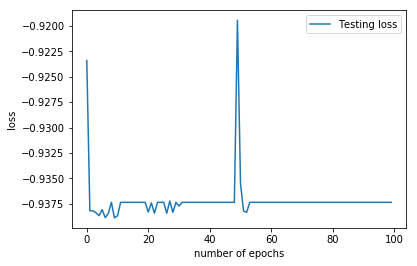

In [10]:
torch.save(model, "MountainCar_model_with_states_n=5") 
# plt.plot(losses, label="Training loss")
plt.plot(test_loss, label="Testing loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# test

In [11]:
y = torch.tensor(testing_set[:, -1], dtype=torch.long)
y_pred = model(testing_set[:, :15])
score, predicted = torch.max(y_pred, 1)
acc = (y == predicted).sum().float() / len(y)
print("accuracy = %.4f "%acc.item())

accuracy = 0.9373 


/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


# PCA

In [6]:
m = torch.load("MountainCar_model_n=3")
m[:8]

Sequential(
  (0): Linear(in_features=3, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=15, bias=True)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=20, bias=True)
  (7): ReLU()
)

In [18]:
s0 = [-1.2, -0.3, 0.6]
s1 = [-0.07, -0.0, 0.07]
a= [0,1,2]
all = []
for i in s0:
    for j in s1:
        for k in a:
            for g in a:
                all.append([i, j,k, g])
torch.tensor(all).shape

torch.Size([81, 4])

In [37]:
def prepare_inputs (n): 
    a=[0, 1,2]
    return torch.tensor([list(i) for i in itertools.product(a, repeat=n)], dtype=torch.float)

In [4]:
def replace (a):
    for i in range(len(a)):
        if a[i]==0:
            a[i]="->"
        elif a[i]==1:
            a[i] = "--"
        elif a[i] == 2:
            a[i] = "<-"
    return a

In [21]:
def plot_kmeans (n, n_clusters = 3):
    a=[0, 1,2]
    m = torch.load("MountainCar_model_n={}".format(n))
    inputs = torch.tensor([list(i) for i in itertools.product(a, repeat=n)], dtype=torch.float)
    embeddings =  m[:8](inputs).detach().numpy()
    pca = PCA(n_components=2, svd_solver='full' ).fit_transform(embeddings)
    gmm = GaussianMixture(n_components= n_clusters).fit_predict(embeddings)
    kmean = KMeans(n_clusters= n_clusters).fit_predict(embeddings)
    
    data = pd.DataFrame(pca)
    data.columns = ['x1', 'x2']
    data['Clusters'] = pd.Series(kmean, index=data.index)
    index = []
    means = []
    std=[]
#     for i in range(n):
#         index.append(list(np.where(kmean==i)[0]))
    for i in range (n_clusters):
        index.append(list(np.where(kmean==i)[0]))
        means.append(np.array(torch.mean(inputs[index[i]],0), dtype=int).tolist())
        std.append(np.array(torch.std(inputs[index[i]],0)).tolist())
        
        k = replace(means[-1])
        c = ", ".join(str(x) for x in k)
        data.Clusters.replace([i], [c], inplace=True)

#     print(data['Clusters'])
    plot = sns.lmplot(data=data, x='x1', y='x2', hue='Clusters', fit_reg=False, legend=True, legend_out=True)
    plot.savefig("fig/MountainCar_Clusters={}_n={}".format(n_clusters,n), dpi=600)
    return  index , means, std

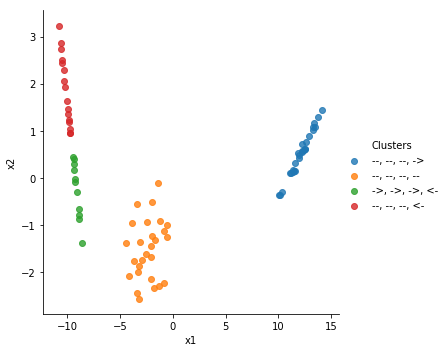

In [22]:
index , means, std = plot_kmeans(4,4)

In [89]:
set(np.array([2,1,1,0,]))

{0, 1, 2}

In [48]:
torch.mean(inputs[index[0]],0).tolist()

[1.0, 1.0, 1.0, 1.0, 0.0]

In [43]:
torch.tensor(torch.mean(inputs[index[1]],0), dtype=torch.int)

/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([1, 2], dtype=torch.int32)

In [127]:
def prepare_inputs (n): 
    st = np.zeros(n*3+1)
#     for i in range (n)
    st[:2] = np.random.randint(-7, 7)/100 , np.random.randint(-12, 6)/10
    st[2:4] = np.random.randint(-7, 7)/100 , np.random.randint(-12, 6)/10
    st[4:] = np.random.randint(0,3), np.random.randint(0,3),np.random.randint(0,3)
    return torch.tensor(st)

In [38]:
prepare_inputs(4).shape

torch.Size([81, 4])

In [39]:
m = torch.load("MountainCar_model_n=4")
m[:8]

Sequential(
  (0): Linear(in_features=4, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=15, bias=True)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=20, bias=True)
  (7): ReLU()
)

In [40]:
zom = prepare_inputs(4)
zom.shape

torch.Size([81, 4])

In [41]:
vectors = m[:8](zom).detach().numpy()
vectors.shape

(81, 20)

In [42]:
pca = PCA(n_components=2, svd_solver='full' ).fit_transform(vectors)
gmm = GaussianMixture(n_components=3).fit_predict(vectors)
kmean = KMeans(n_clusters=4).fit_predict(vectors)

In [43]:
",".join(str(x) for x in [1,2,3])

'1,2,3'

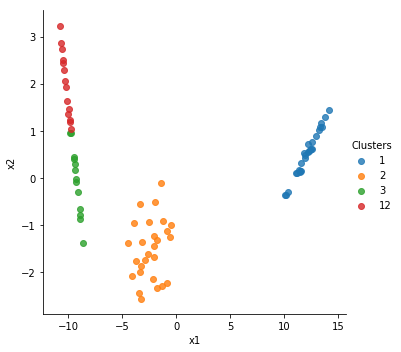

In [58]:
data = pd.DataFrame(pca)
data.columns = ['x1', 'x2']
data['Clusters'] = pd.Series(kmean, index=data.index)
# data['Clusters'] = data['Clusters'].map({1: "1,22,,3,"})
data.Clusters.replace([0], [12], inplace=True)

# data['label'] = data['label'].map({1: " ".join(str(x) for x in [1,2,3]), 0: " ".join(str(x) for x in [1,2])})
plot = sns.lmplot(data=data, x='x1', y='x2', hue='Clusters', fit_reg=False, legend=True, legend_out=True)
# plot.savefig("fig/output", dpi=600)

In [90]:
gmm = GaussianMixture(n_components=3)
gmm.fit(vectors)
gmm.get_params()

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 3,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

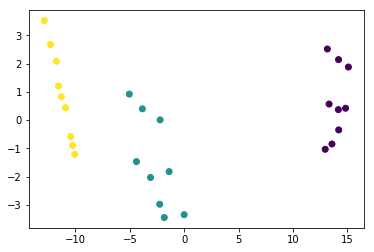

In [72]:
plt.scatter(pca[:, 0], pca[:, 1], c=gmm)

# Kmeans

In [54]:
zom[0]

tensor([0., 0., 0.])

Text(0.5,1,'Kmeans Act2Vec Walker2d n=5')

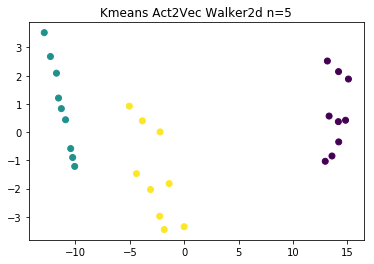

In [58]:
kmean = KMeans(n_clusters=3, random_state=0).fit_predict(pca)
plt.scatter(pca[:, 0], pca[:, 1], c=kmean)
# for i in range (zom.shape[0]):
#     plt.plot(pca[i,0], pca[i,1],"x" ,  label="{}".format(zom[i]))
# plt.legend()
plt.title("Kmeans Act2Vec Walker2d n=5")

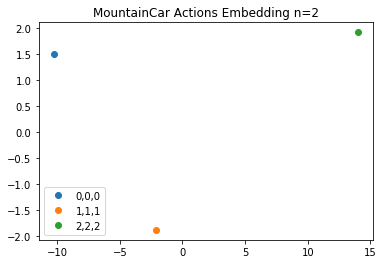

In [17]:
# for i in range (pca.shape[0]):
#     plt.plot(list(pca[i])[0], list(pca[i])[1] ,"o", label="{}".format(list(np.array(zom[i], dtype=np.int))))
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"o", label="0,0,0")
# plt.plot(list(pca[2])[0], list(pca[1])[1] ,"o", label="0,0,2")
# plt.plot(list(pca[6])[0], list(pca[3])[1] ,"o", label="0,2,0")
# plt.plot(list(pca[19])[0], list(pca[3])[1] ,"o", label="2,0,0")
plt.plot(list(pca[4])[0], list(pca[4])[1] ,"o", label="1,1,1")
plt.plot(list(pca[-1])[0], list(pca[-1])[1] ,"o", label="2,2,2")
plt.title("MountainCar Actions Embedding with states n=2")
plt.legend()
plt.savefig("fig/MountainCar_with_states_n=2", dpi=600)

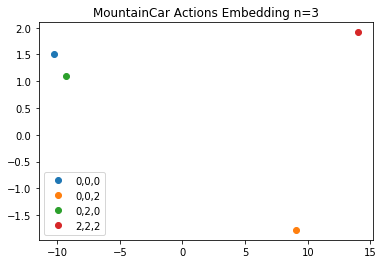

In [19]:
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"o", label="0,0,0")
plt.plot(list(pca[2])[0], list(pca[1])[1] ,"o", label="0,0,2")
plt.plot(list(pca[6])[0], list(pca[3])[1] ,"o", label="0,2,0")
# plt.plot(list(pca[19])[0], list(pca[3])[1] ,"o", label="2,0,0")
plt.plot(list(pca[-1])[0], list(pca[-1])[1] ,"o", label="2,2,2")

plt.title("MountainCar Actions Embedding n=3")
plt.legend()